# <p style='text-align: center;'> Проверка гипотез </p><a class="tocSkip">
## Загрузка и первичный анализ таблицы 

**Данные для первой части**

***Файл /datasets/hypothesis.csv. ***

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


**Данные для второй части**

***Файл /datasets/orders.csv.***

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.


***Файл /datasets/visitors.csv.***

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста


1. Выбрать наиболее приоритетную гипотезу.


2. Проанализировать результаты АВ-теста:
 
 
* Сравнить кумулятивную выручку, кумулятивный средний чек и кумулятивную конверсию по группам.
* Рассмотреть распределение количества заказов по пользователям, отфильтровать аномальные значения.
* Рассмотреть распределение заказов по стоимости, отфильтровать аномальные значения.
* Посчитать по критерию Манна-Уитни, действительно ли конверсия и средний чек между группами различается.
* Сделать вывод о правильности проверяемой гипотезы

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
from datetime import datetime, timedelta
import statsmodels
import numpy as np
from statsmodels.stats.stattools import medcouple

from scipy import stats as st
import math as mth

%matplotlib inline

### Запись данных в переменные

In [2]:
try:
    hypothesis = pd.read_csv(r'C:\Users\Ярослава\Downloads\hypothesis.csv') # personal path
    orders = pd.read_csv(r'C:\Users\Ярослава\Downloads\orders.csv') # personal path
    visitors = pd.read_csv(r'C:\Users\Ярослава\Downloads\visitors.csv') # personal path
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv') # personal path
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv') # personal path
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv') # personal path
    
hypothesis.columns = [x.lower().replace(' ', '_') for x in hypothesis.columns]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]
visitors.columns = [x.lower().replace(' ', '_') for x in visitors.columns]    

### Первичное исследование данных
#### Проверка типов данных

In [3]:
# проверям данные таблицы orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionid    1197 non-null int64
visitorid        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.8+ KB


In [4]:
# проверям данные таблицы visitors
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.5+ KB


Данные в колонках date приводим к типу datetime

In [5]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

**Вывод:** Типы данных корректны

#### Проверка на наличие пропусков  и дубликатов

In [6]:
def nan_values(df):
    count_mising = df.isna().sum()
    percent_missing = round(count_mising * 100 / len(df), 2)
    missing_values_df = pd.DataFrame({'count_mising':count_mising,
                                     'percent_missing':percent_missing})
    return missing_values_df.query('count_mising != 0')
nan_values(orders)

,count_mising,percent_missing


In [7]:
nan_values(visitors)

,count_mising,percent_missing


In [8]:
print('Дубликатов в таблице orders:', orders.duplicated().sum())
print('Дубликатов в таблице visitors:', visitors.duplicated().sum())

Дубликатов в таблице orders: 0
Дубликатов в таблице visitors: 0


**Вывод:** Пропусков и дубликатов нет

####  Пересекаются ли пользователи для разных групп

In [9]:
# разделяем таблицу orders на группы
orders_a = orders.query('group == "A"')
orders_b = orders.query('group == "B"')

# определяем id пользователей, которые присутствуют в двух группах сразу
common_users = orders_a[orders_a.visitorid.isin(orders_b.visitorid)].visitorid

Для чистоты эксперимента пользователи должны быть строго разделены по группам. Поэтому тех, кто оказался и в группе А и в группе В нужно удалить.

In [10]:
orders = orders[np.logical_not(orders['visitorid'].isin(common_users))]

**Вывод:** Очистили таблицу orders от пересекающихся пользователей

## Приоретизация гипотез

### Фреймворк ICE

Применить фреймворк ICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

In [11]:
hypothesis['ice'] = hypothesis.impact * hypothesis.confidence / hypothesis.efforts 
hypothesis.sort_values('ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000


### Фреймворк RICE

Применить фреймворк RICE для приоритизации гипотез. Отсортировать их по убыванию приоритета.

In [12]:
hypothesis['rice'] = hypothesis.reach * hypothesis.impact * hypothesis.confidence / hypothesis.efforts 
hypothesis.sort_values('rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0


### Вывод

Приоритеты гипотез по RICE поменялись. Гипотеза №7 вышла вперед из-за сильного влияния праметра reach - в 10 раз большего, чем у гипотезы №8. ICE от RICE отличается тем, что параметр RICE учитывает охват пользователей. Гипотеза №8, занявшее первое место по параметру ICE имеет высокие значения impact (насколько сильно изменение повлияет на охваченных пользователей) confidence (то, насколько вы уверены в оценках других параметров). Но охват пользователей у нее низкий - каждый день она будет оказывать влияние только на 1/365 долю всех зарегистрированных пользователей. За месяц исследования это коснется только 8% уже имеющихся клиентов и не повлияет на привлечение новых. 

В то же время, охват гипотезы 7 самый большой. Она коснется всех клиентов (и потенциальных и уже имеющихся), которые заходят на сайт компании. Поэтому даже при значениях impact и confidence чуть ниже, чем у гипотезы 8, 7-я гипотеза является более приоритеной.

## Анализ A/B-теста

###  Кумулятивная выручка

Построить график кумулятивной выручки по группам. 

In [13]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups.head(6)

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
66,2019-08-01,B


In [14]:
# агрегированные кумулятивные по дням данные о заказах
ordersAggregated = (
    datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                           orders['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'transactionid' : 'nunique', 
                 'visitorid' : 'nunique', 
                 'revenue' : 'sum'}), 
           axis=1)
    .sort_values(by=['date','group'])
                   )
ordersAggregated.head()

,date,group,transactionid,visitorid,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [15]:
# агрегированные кумулятивные по дням данные о визитах
visitorsAggregated = (
    datesGroups
    .apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], 
                                             visitors['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'visitors' : 'sum'}),
           axis=1)
    .sort_values(by=['date','group'])
                     )

visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [16]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


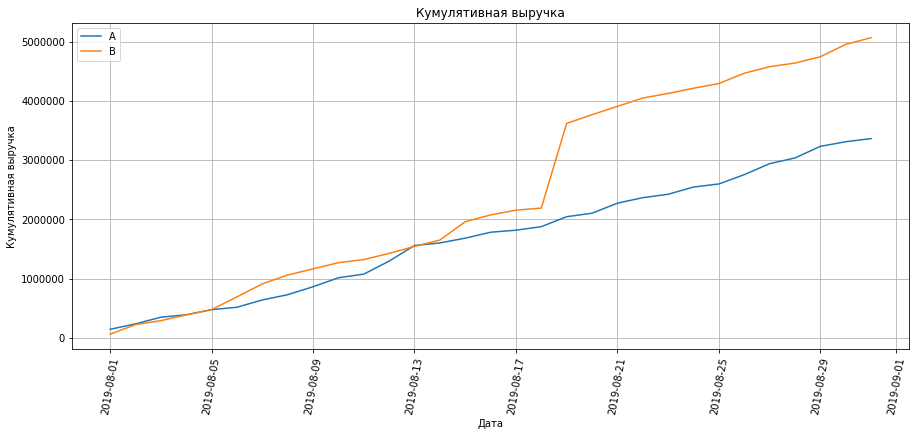

In [17]:
# датафрейм с кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue']]

# датафрейм с кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue']]

plt.figure(figsize=(15,6))
plt.title('Кумулятивная выручка')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=80)
plt.grid()
plt.legend()


Начиная с 6го дня выручка группы B стабильно выше, чем выручка группы А. С 19-08-2019 эта разница резко увеличивается. Значит, в этот день в группе В была совершена крупная покупка. Угла наклона кривых примерно одинаковые , что означает равномерность прироста выручки ото дня ко дню. Проверим выручку группы B на наличие выбросов.

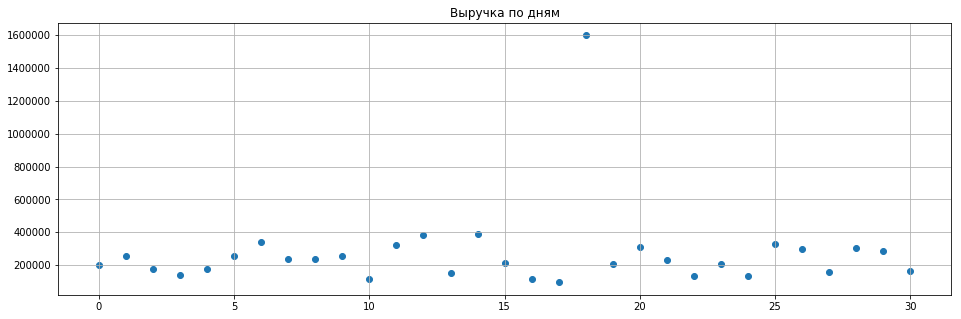

In [18]:
visitors_purchases = orders.groupby('date')['revenue'].sum()

plt.figure(figsize=(16,5))
plt.title('Выручка по дням')
x_values = pd.Series(range(0,len(visitors_purchases)))

plt.scatter(x_values, visitors_purchases) 
plt.grid()

19-08-2019 имеется выброс.

In [19]:
orders_b.query('date == datetime(2019, 8, 19).date()')

,transactionid,visitorid,date,revenue,group
315,1939633950,157579733,2019-08-19,2330,B
319,2414788465,2247745159,2019-08-19,1435,B
320,1652782757,2763027084,2019-08-19,1460,B
322,3154167297,2091902649,2019-08-19,250,B
363,2096847394,4251115836,2019-08-19,2500,B
367,1033377712,3860669668,2019-08-19,3990,B
368,3268879337,2536252163,2019-08-19,20026,B
423,4161654914,990904712,2019-08-19,11249,B
424,2609443403,2406916810,2019-08-19,470,B
425,590470918,1920142716,2019-08-19,1294500,B


In [20]:
# удаляем из таблицы orders строку с индексом [425]
orders = orders.drop(index=[425])

Заново строим графики кумулятивной выручки

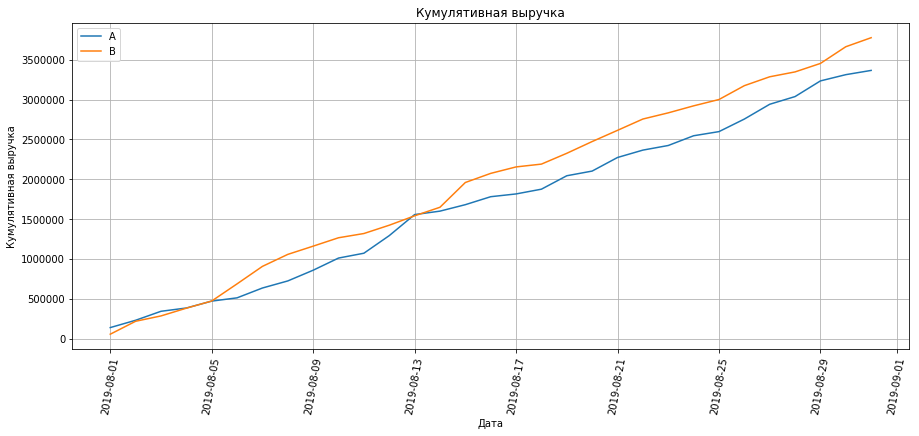

In [21]:
# агрегированные кумулятивные по дням данные о заказах
ordersAggregated = (
    datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                           orders['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'transactionid' : 'nunique', 
                 'visitorid' : 'nunique', 
                 'revenue' : 'sum'}), 
           axis=1)
    .sort_values(by=['date','group'])
)
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
    
# датафрейм с кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue']]

# датафрейм с кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue']]

plt.figure(figsize=(15,6))
plt.title('Кумулятивная выручка')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=80)
plt.grid()
plt.legend()

График очищен от выбросов. Выручка по группе В стабильно выше, чем по группе А. За исключением первых пяти дней и дня 13-08-2019, когда кумулятивные выручки были примерно равны. Очевидно 13-08-2019 было сделано покупок на большую сумму. 

### Кумулятивный средний чек

In [22]:
cumulativeData['avarage_bill'] = cumulativeData['revenue'] / cumulativeData['buyers']

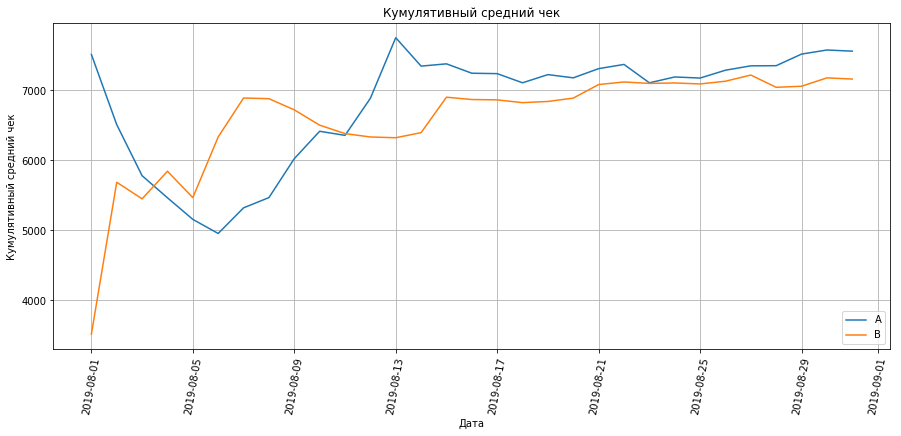

In [23]:
# датафрейм с кумулятивным средним чеком по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','avarage_bill']]

# датафрейм с кумулятивным средним чеком по дням в группе  B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','avarage_bill']]

plt.figure(figsize=(15,6))
plt.title('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')

# Строим график среднего чека группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['avarage_bill'], label='A')

# Строим график среднего чека группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['avarage_bill'], label='B')

plt.xticks(rotation=80)
plt.grid()
plt.legend()

Предположение, высказанное выше подтвердилось. 13-08-2019 виден резкий рост среднего чека по группе А. Кроме того, график кумулятивного среднего чека по группе А на бОльшей части графика лежит выше графика кумулятивного среднего чека по группе B, при том, что кумулятивная выручка по группе А ниже. Скорее всего, это говорит о том, что покупатели из группы А делают меньше покупок, но они крупнее по сумме.

### Относительное изменение кумулятивного среднего чека

Построить график относительного изменения кумулятивного среднего чека группы B к группе A

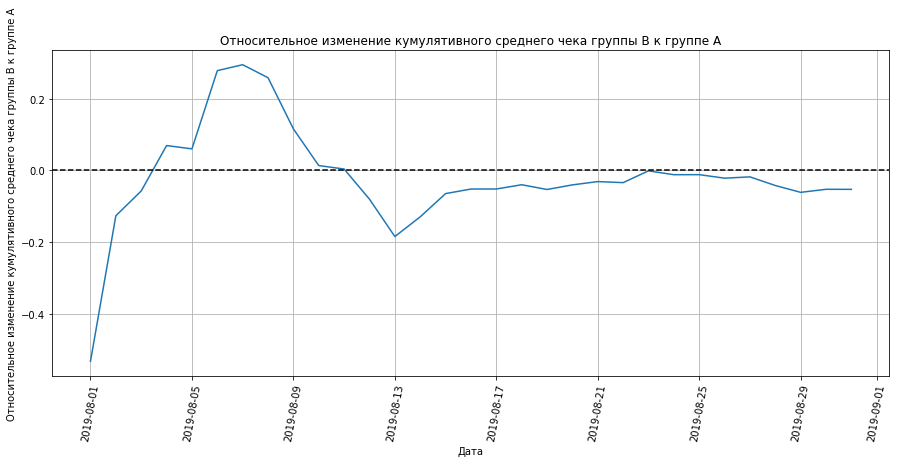

In [24]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,6))
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивного среднего чека группы B к группе A')

# cтроим отношение средних чеков
plt.plot(
         mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['avarage_billB']/mergedCumulativeRevenue['avarage_billA'])-1
        )

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=80)
plt.grid()

По графику относительного изменения кумулятивного среднего чека видны периоды, когда кумулятивный средний чек по группе B был ниже кумулятивного среднего чека по группе А (график ниже нуля).

###  Кумулятивная конверсия

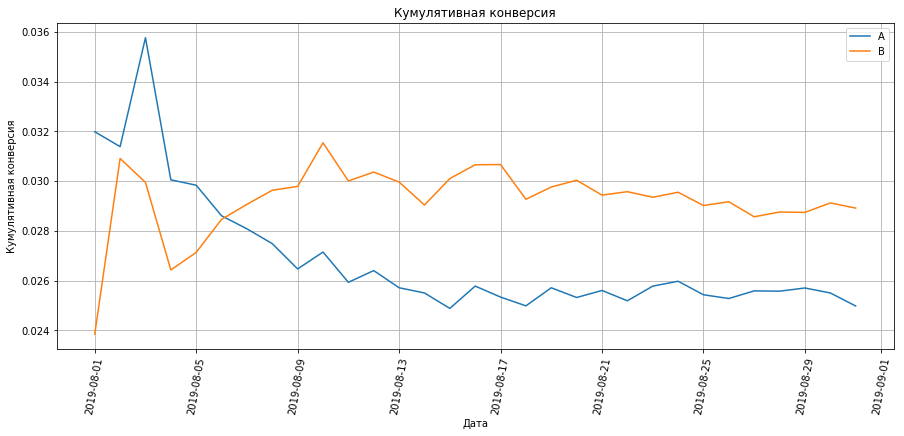

In [25]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(15,6))
plt.title('Кумулятивная конверсия')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.xticks(rotation=80)
plt.grid()
#plt.axis(["2019-08-01", '2019-08-31', 0, 0.037])

Конверсия в группе В стабильно выше начиная с 06-08-2019 (с того же дня, что и комулятивная выручка). Похоже, что реклама либо условия для группы B были существенно лучше, чем для группы А.

### Относительное изменение кумулятивной конверсии

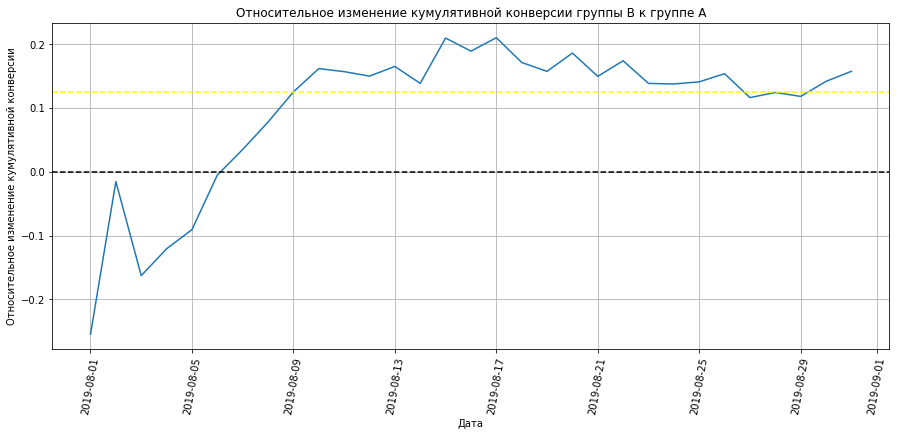

In [26]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(15,6))
plt.title('Относительное изменение кумулятивной конверсии группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивной конверсии')

plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.125, color='yellow', linestyle='--')
plt.xticks(rotation=80)
plt.grid()

Относительная кумулятивная конверсия группы B к группе A бальше нуля с 06-08-2019

### Количество заказов по пользователям

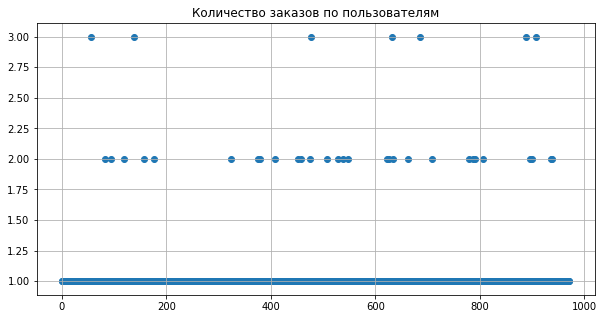

In [27]:
visitors_purchases = orders.groupby('visitorid')['revenue'].count()

plt.figure(figsize=(10,5))
plt.title('Количество заказов по пользователям')
x_values = pd.Series(range(0,len(visitors_purchases)))

plt.scatter(x_values, visitors_purchases) 
plt.grid()

Подавляющее большенство пользователей совершили одну покупку. Были те, кто совершил 2 и 3 покупоки.

### Перцентили количества заказов

In [28]:
print(np.percentile(visitors_purchases, [95, 99]))

[1. 2.]


Не более 1% покупателей совершили 2 покупки. Не более 1% - 2 покупки. В качестве границы для аномальных пользователей выбираем 3 покупки.

### Cтоимости заказов

In [29]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


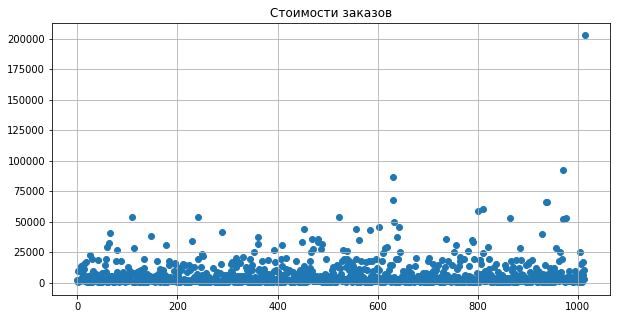

In [30]:
plt.figure(figsize=(10,5))
plt.title('Стоимости заказов')
x_values = pd.Series(range(0,len(orders)))

plt.scatter(x_values, orders['revenue']) 
plt.grid()

Подавляющее большенство покупок на сумму в пределах 50000. Есть аномалии - больше 200 000

### Перцентили стоимости заказов

In [31]:
print(np.percentile(orders['revenue'], [95, 99]))

[26550.   53763.44]


Не более 5% покупок совершено на сумму 26550. Не более 1% - на сумму 53763,44. В качестве границы для аномальных покупок выбираем 26550.

In [32]:
statsmodels.stats.stattools.medcouple(orders['revenue'])

array(0.55499701)

### Статистическая значимость различий в конверсии по сырым данным

**Введем нулевую и альтернативные гипотезы**:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Различий в конверсии между группами нет}\\
   H_1 :\text{Различия в конверсии между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Рассчитаем p-value. Если p-value будет меньше выбранного уровня значимости ($\alpha = 0.05$), то будут основания отвергнуть нулевую гипотезу в пользу альтернативной. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [34]:
# Сбор данных

# Группа А
daily_visitors_a = visitors.query('group == "A"')[['date', 'visitors']]

# С помощью lambda-функции итерируемся по каждой строке датафрейма и сравниваем: 
# если дата или даты (если прошли больше n итераций) (daily_visitors_a['date']) 
# меньше даты в текущей ячейке, в которой мы находимся на конкретном шаге итерации (x['date']), 
# то суммируй ее/их значения столбца visitors со значением visitors в текущей ячейке ('visitors': 'sum'), 
# а дату оставляй максимальную из 2-х/3-х/n ('date': 'max'). 
# Таким образом, получаем кумулятивную сумму для каждой даты, учитывая предыдущие (меньшие) даты.

cum_visitors_a = daily_visitors_a.apply(
    lambda x: daily_visitors_a[daily_visitors_a['date'] <= x['date']]
    .agg({'date': 'max',
          'visitors': 'sum'}), axis=1)

cum_visitors_a.columns = [
    'date', 
    'num_visitors_a'
]

daily_orders_a = (
    orders
    .query('group == "A"')[['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': 'nunique',
          'revenue': 'sum'})
)


cum_orders_a = daily_orders_a.apply(
    lambda x: daily_orders_a[daily_orders_a['date'] <= x['date']]
    .agg({'date': 'max', 
          'transactionid': 'sum', 
          'revenue': 'sum'}), axis=1).sort_values(by=['date'])

cum_orders_a.columns = [
    'date',
    'num_orders_a',
    'revenue_a',
]

In [35]:
# Группа B
daily_visitors_b = visitors.query('group == "B"')[['date', 'visitors']]

cum_visitors_b = daily_visitors_b.apply(
    lambda x: daily_visitors_b[daily_visitors_b['date'] <= x['date']] # 
    .agg({'date': 'max',
          'visitors': 'sum'}), axis=1)

cum_visitors_b.columns = [
    'date', 
    'num_visitors_b'
]

daily_orders_b = (
    orders
    .query('group == "B"')[['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': 'nunique',
          'revenue': 'sum'})
)


cum_orders_b = daily_orders_b.apply(
    lambda x: daily_orders_b[daily_orders_b['date'] <= x['date']]
    .agg({'date': 'max', 
          'transactionid': 'sum', 
          'revenue': 'sum'}), axis=1).sort_values(by=['date'])

cum_orders_b.columns = [
    'date',
    'num_orders_b',
    'revenue_b',
]

In [36]:
# Объединение

final_data = (
    daily_orders_a.merge(
        daily_orders_b, left_on='date', right_on='date', how='left'
    )
    .merge(cum_orders_a, left_on='date', right_on='date', how='left')
    .merge(cum_orders_b, left_on='date', right_on='date', how='left')
    .merge(daily_visitors_a, left_on='date', right_on='date', how='left')
    .merge(daily_visitors_b, left_on='date', right_on='date', how='left')
    .merge(cum_visitors_a, left_on='date', right_on='date', how='left')
    .merge(cum_visitors_b, left_on='date', right_on='date', how='left')
)

In [37]:
# Переменные для определения статистической значимости в конверсии между группами по «сырым» данным

# Группа А
orders_by_users_a = (
    orders.query('group == "A"')
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)

orders_by_users_a.columns = ['visitorid', 'num_orders']

sample_a = pd.concat(
    [
        orders_by_users_a['num_orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_x'].sum() - len(orders_by_users_a['num_orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [38]:
# Группа В

orders_by_users_b = (
    orders.query('group == "B"')
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': 'nunique'})
)

orders_by_users_b.columns = ['visitorid', 'num_orders']

sample_b = pd.concat(
    [
        orders_by_users_b['num_orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_y'].sum() - len(orders_by_users_b['num_orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [39]:
alpha = .05

results = st.mannwhitneyu(sample_a, sample_b, alternative='two-sided')[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергунть нулевую гипотезу')
    
print('Относительный прирост конверсии группы В к конверсии группы А в процентах:',
      "{0:.2f}".format(((final_data['transactionid_y'].sum() / final_data['visitors_y'].sum()) /
      (final_data['transactionid_x'].sum() / final_data['visitors_x'].sum()) - 1) * 100), '%')

p-value: 0.012036
Имеются основания отвергнуть нулевую гипотезу
Относительный прирост конверсии группы В к конверсии группы А в процентах: 15.77 %


**Вывод:**
Статистическая значимость < 0.05. Отвергаем нулевую гипотезу - различия в конверсии между группами есть.

### Cтатистическая значимость различий в среднем чеке заказа

**Введем нулевую и альтернативные гипотезы**:

$\begin{equation*}
 \begin{cases}
   H_0 :\text{Различий в среднем чеке между группами нет}\\
   H_1 :\text{Различия в среднем чеке между группами есть.}
 \end{cases}
\end{equation*}$

Уровень значимости: $\alpha = 0.05$

Рассчитаем p-value. Если p-value будет меньше выбранного уровня значимости ($\alpha = 0.05$), то будут основания отвергнуть нулевую гипотезу в пользу альтернативной. Иначе сделаем вывод, что данные не позволили нам отвергнуть нулевую гипотезу.

In [49]:
results = st.mannwhitneyu(
    orders.query('group == "A"')['revenue'],
    orders.query('group == "B"')['revenue'],
    alternative='two-sided')[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергунть нулевую гипотезу')
    
print('Относительный прирост среднего чека группы B:',
      '{0:.2f}'.format((orders.query('group == "B"')['revenue'].mean() /
                        orders.query('group == "A"')['revenue'].mean() - 1) * 100), '%')

p-value: 0.790301
Недостаточно оснований, чтобы отвергунть нулевую гипотезу
Относительный прирост среднего чека группы B: -4.02 %


**Вывод:** Статистическая значимость > 0.05. Принимаем нулевую гипотезу - различий в среднем чеке заказа между группами нет.

### Статистическая значимость различий в конверсии по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от 3 заказов или совершил заказ дороже 28 000 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов до 5% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 3 — usersWithManyOrders и пользователей, совершивших заказы дороже 28 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.

In [50]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 26650]['visitorid']

abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Aномальных пользователей', abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
Aномальных пользователей 57


In [57]:
sample_a_normal = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_x'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_b_normal = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                final_data['visitors_y'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [59]:
results = st.mannwhitneyu(
    sample_a_normal, 
    sample_b_normal, 
    alternative='two-sided')[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергунть нулевую гипотезу')
    
print('Относительный прирост конверсии группы В к конверсии группы А:',
      '{0:.2f}'.format((sample_b_normal.mean() / sample_a_normal.mean() - 1) * 100), '%')

p-value: 0.012380
Имеются основания отвергнуть нулевую гипотезу
Относительный прирост конверсии группы В к конверсии группы А: 18.18 %


**Вывод:**
p-value почти не изменился, и вывод тот же - различия в конверсии между группами есть.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [61]:
results = st.mannwhitneyu(
    orders[
        np.logical_and(
            orders['group'] == 'A',
            np.logical_not(orders['visitorid'].isin(abnormalUsers))
        )
    ]['revenue'],
    orders[
        np.logical_and(
            orders['group'] == 'B',
            np.logical_not(orders['visitorid'].isin(abnormalUsers))
        )
    ]['revenue'])[1]

print('p-value:', '{0:.6f}'.format(results))

if (results < alpha):
    print('Имеются основания отвергнуть нулевую гипотезу')
else:
    print('Недостаточно оснований, чтобы отвергунть нулевую гипотезу')
    
print(
    'Относительный прирост среднего чека группы B к среднему чеку группы А:',
    "{0:.2f}".format((
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean() - 1) * 100), '%') 

p-value: 0.322948
Недостаточно оснований, чтобы отвергунть нулевую гипотезу
Относительный прирост среднего чека группы B к среднему чеку группы А: -4.85 %


**Вывод:**
p-value незначительно уменьшился, но вывод тот же -  различий в среднем чеке заказа между группами нет.

 ### Решение по результатам теста

Результаты АВ-теста:

* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
* Нет статистически значимого различия по среднему чеку между группами как по сырым данным, так и после фильтрации аномалий.
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту, либо зафиксировались около среднего значения 0.125.
* График различия среднего чека колеблется.

Решение: остановить тест, признать его успешным и зафиксировать победу группы В